In [148]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Upload the data

In [149]:
data = pd.read_csv('Lome.csv')
data.head()

,Date,Consumption,Pop,Tmean,RH,Wind,Consumption/KWH
0,01/01/2013,1613.0,1667113,27.5,60.7,2.84,0.967541
1,02/01/2013,1860.0,"1,667,333",26.7,66.1,2.20,1.115554
2,03/01/2013,1860.0,"1,667,553",27.0,73.3,2.05,1.115407
3,04/01/2013,2142.0,"1,667,773",27.6,73.1,1.88,1.284347
4,05/01/2013,1878.0,"1,667,993",27.2,70.9,2.45,1.125904


In [150]:
#data.Date = data.Date.map(lambda date: date.split('/')[1] + '/' + date.split('/')[0] + '/' + date.split('/')[-1])

In [151]:
#data.Date[1].split('/')[1] + '/' + data.Date[1].split('/')[0] + '/' + data.Date[1].split('/')[-1]
#data

In [152]:
# Remove the Date, Consumption and Population
data_dropped = data.drop(columns = ['Consumption', 'Pop'])
data_dropped.head()

,Date,Tmean,RH,Wind,Consumption/KWH
0,01/01/2013,27.5,60.7,2.84,0.967541
1,02/01/2013,26.7,66.1,2.20,1.115554
2,03/01/2013,27.0,73.3,2.05,1.115407
3,04/01/2013,27.6,73.1,1.88,1.284347
4,05/01/2013,27.2,70.9,2.45,1.125904


In [153]:
# set the Date as datetime
data_dropped['Date'] = pd.to_datetime(data_dropped['Date'])
data_dropped

,Date,Tmean,RH,Wind,Consumption/KWH
0,2013-01-01,27.5,60.7,2.84,0.967541
1,2013-02-01,26.7,66.1,2.20,1.115554
2,2013-03-01,27.0,73.3,2.05,1.115407
3,2013-04-01,27.6,73.1,1.88,1.284347
4,2013-05-01,27.2,70.9,2.45,1.125904
...,...,...,...,...,...
1456,2016-12-27,27.0,74.4,1.95,1.312248
1457,2016-12-28,26.6,73.4,1.98,1.338931
1458,2016-12-29,26.4,73.8,1.93,1.304959
1459,2016-12-30,26.4,78.5,2.15,1.299327


In [154]:
data_dropped.set_index('Date', inplace=True)
df1 = data_dropped.asfreq('D')
df1

,Tmean,RH,Wind,Consumption/KWH
Date,,,,
2013-01-01,27.5,60.7,2.84,0.967541
2013-01-02,27.9,56.3,2.76,1.301127
2013-01-03,29.2,80.2,3.96,1.424920
2013-01-04,28.5,78.4,3.16,1.096676
2013-01-05,25.9,88.8,2.03,1.010325
...,...,...,...,...
2016-12-27,27.0,74.4,1.95,1.312248
2016-12-28,26.6,73.4,1.98,1.338931
2016-12-29,26.4,73.8,1.93,1.304959


In [155]:
df1_resampled = df1.resample('W').mean()
df1_resampled

,Tmean,RH,Wind,Consumption/KWH
Date,,,,
2013-01-06,27.650000,74.850000,2.980000,1.155943
2013-01-13,26.428571,81.828571,3.494286,1.140486
2013-01-20,28.485714,80.842857,3.384286,1.332617
2013-01-27,28.485714,80.428571,3.667143,1.327037
2013-02-03,27.871429,73.671429,2.687143,1.271762
...,...,...,...,...
2016-12-04,28.385714,81.428571,3.244286,1.415145
2016-12-11,26.300000,85.314286,3.438571,1.203439
2016-12-18,27.942857,83.200000,2.645714,1.371090


In [156]:
# initialize the MinMaxScaler object
scaler = MinMaxScaler()

# fit the scaler object to the dataframe
scaler.fit(df1_resampled)

# transform the dataframe to the scaled values
data_normalized = scaler.transform(df1_resampled)
data_normalized 

array([[0.63031161, 0.57787762, 0.40474997, 0.22625578],
       [0.38810198, 0.78690629, 0.62120453, 0.18555654],
       [0.79603399, 0.75738126, 0.57490731, 0.69145579],
       [0.79603399, 0.74497219, 0.69395731, 0.67676416],
       [0.67422096, 0.54257595, 0.28149113, 0.53121926],
       [0.33144476, 0.81386393, 0.500952  , 0.36685445],
       [0.79320113, 0.77321352, 0.67712196, 0.560466  ],
       [0.82152975, 0.71116816, 0.69275479, 0.66705491],
       [0.7733711 , 0.67950364, 0.59414771, 0.55741695],
       [0.36260623, 0.8245614 , 0.6554765 , 0.48997949],
       [0.77620397, 0.75267437, 0.60136286, 0.73724518],
       [0.89235127, 0.70261018, 0.83886161, 0.80973695],
       [0.83286119, 0.66452717, 0.60196412, 0.79863921],
       [0.66005666, 0.72058194, 0.59054013, 0.58582055],
       [0.49575071, 0.80530595, 0.5652871 , 0.40587834],
       [0.80736544, 0.70047069, 0.50756589, 0.76003918],
       [0.72521246, 0.73727   , 0.33079467, 0.57008881],
       [0.77053824, 0.6961917 ,

In [157]:
# create a new dataframe with the scaled values
df2 = pd.DataFrame(data_normalized, columns=df1_resampled.columns)
df2.index = df1_resampled.index
# print the scaled dataframe
df2

,Tmean,RH,Wind,Consumption/KWH
Date,,,,
2013-01-06,0.630312,0.577878,0.404750,0.226256
2013-01-13,0.388102,0.786906,0.621205,0.185557
2013-01-20,0.796034,0.757381,0.574907,0.691456
2013-01-27,0.796034,0.744972,0.693957,0.676764
2013-02-03,0.674221,0.542576,0.281491,0.531219
...,...,...,...,...
2016-12-04,0.776204,0.774925,0.515984,0.908761
2016-12-11,0.362606,0.891314,0.597755,0.351318
2016-12-18,0.688385,0.827985,0.264055,0.792758


,Tmean,RH,Wind,Consumption/KWH
Date,,,,
2013-01-06,0.630312,0.603979,0.404750,0.226256
2013-01-13,0.388102,0.786906,0.621205,0.185557
2013-01-20,0.796034,0.757381,0.574907,0.691456
2013-01-27,0.796034,0.744972,0.693957,0.676764
2013-02-03,0.674221,0.603979,0.281491,0.531219
...,...,...,...,...
2016-12-04,0.776204,0.774925,0.515984,0.908761
2016-12-11,0.362606,0.891314,0.597755,0.351318
2016-12-18,0.688385,0.827985,0.264055,0.792758


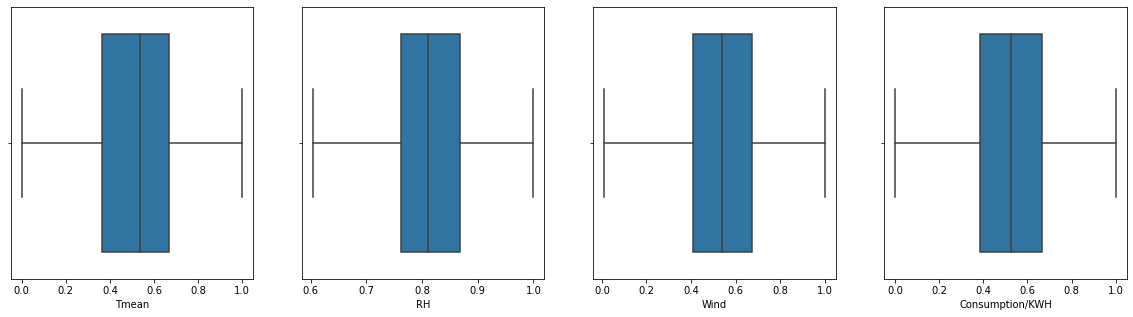

In [158]:
def remove_outliers(df2):
    # calculate the lower and upper bounds for outliers
    Q1 = df2['Tmean'].quantile(0.25)
    Q3 = df2['Tmean'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # replace outliers below lower bound with lower bound and above upper bound with upper bound
    df2.loc[df2['Tmean'] < lower_bound, 'Tmean'] = lower_bound
    df2.loc[df2['Tmean'] > upper_bound, 'Tmean'] = upper_bound
    
    # calculate the lower and upper bounds for outliers
    Q1 = df2['RH'].quantile(0.25)
    Q3 = df2['RH'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # replace outliers below lower bound with lower bound and above upper bound with upper bound
    df2.loc[df2['RH'] < lower_bound, 'RH'] = lower_bound
    df2.loc[df2['RH'] > upper_bound, 'RH'] = upper_bound
    
    # calculate the lower and upper bounds for outliers
    Q1 = df2['Wind'].quantile(0.25)
    Q3 = df2['Wind'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # replace outliers below lower bound with lower bound and above upper bound with upper bound
    df2.loc[df2['Wind'] < lower_bound, 'Wind'] = lower_bound
    df2.loc[df2['Wind'] > upper_bound, 'Wind'] = upper_bound
    
    # calculate the lower and upper bounds for outliers
    Q1 = df2['Consumption/KWH'].quantile(0.25)
    Q3 = df2['Consumption/KWH'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # replace outliers below lower bound with lower bound and above upper bound with upper bound
    df2.loc[df2['Consumption/KWH'] < lower_bound, 'Consumption/KWH'] = lower_bound
    df2.loc[df2['Consumption/KWH'] > upper_bound, 'Consumption/KWH'] = upper_bound
    
    # plot boxplots for each column
    fig, axs = plt.subplots(ncols=4, figsize=(20,5))
    sns.boxplot(x=df2['Tmean'], ax=axs[0])
    sns.boxplot(x=df2['RH'], ax=axs[1])
    sns.boxplot(x=df2['Wind'], ax=axs[2])
    sns.boxplot(x=df2['Consumption/KWH'], ax=axs[3])
    
    return df2
remove_outliers(df2)

# Correlation matrix

In [ ]:
# Select only the relevant columns
cols = ['Consumption/KWH','Tmean', 'RH', 'Wind']
data_subset = df2.loc[:, cols]

# Compute the correlation matrix
corr_matrix = data_subset.corr()
 
# Create a heatmap plot of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='viridis')

# Show the plot
plt.show()

# XGBoost 

In [146]:
train_size = int(0.8 * df2.shape[0])  # the number of elements we want in the training set.
train = df2.iloc[:train_size, :] # selecting all the rows and stops in the train size and all the columns are included.
test = df2.iloc[train_size:, :] # selecting starts from the train size untill the end of the dataset, and all the columns as well.

In [147]:

# Assuming you have the training and test data
train_data = train[['Tmean', 'RH', 'Wind', 'Consumption/KWH']]
test_data = test[['Tmean', 'RH', 'Wind', 'Consumption/KWH']]
# Scale the data
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_data)
# test_scaled = scaler.transform(test_data)

# Split the data into input (X) and target (y) variables
X_train = train_data.iloc[:, :-1] # all the columns except the last one.
y_train = train_data.iloc[:, -1] # aselecting the last column.
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [14]:
import xgboost as xgb
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       early_stopping_rounds=50,
                       max_depth=3,
                       learning_rate=0.09)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:14:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.17460	validation_1-rmse:0.20728
[100]	validation_0-rmse:0.05068	validation_1-rmse:0.08236
[175]	validation_0-rmse:0.03778	validation_1-rmse:0.08250


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [15]:
predictions_test = reg.predict(X_test)
predictions_train = reg.predict(X_train)

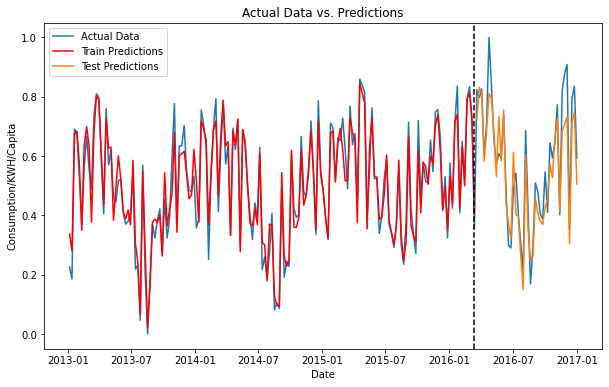

In [16]:
# Plot the actual data, predictions on the training set, and predictions on the test set
plt.figure(figsize=(10, 6))

plt.plot( df2[['Consumption/KWH']], label='Actual Data')
plt.plot(train.index, predictions_train, label='Train Predictions', color = 'red')
plt.plot(test.index, predictions_test, label='Test Predictions')

# Add a vertical line to separate train and test predictions
plt.axvline(x=train.index[-1], color='black', linestyle='--')


plt.xlabel('Date')
plt.ylabel('Consumption/KWH/Capita')
plt.title('Actual Data vs. Predictions')
plt.legend()
plt.show()

## Loss

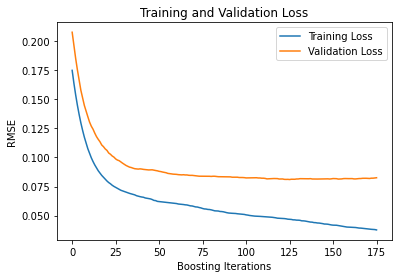

In [17]:
# Assuming that you have already trained the XGBRegressor model and saved it to the variable `reg`
eval_results = reg.evals_result()

# Extract the training and validation loss values from the `eval_results` dictionary
train_loss = eval_results['validation_0']['rmse']
val_loss = eval_results['validation_1']['rmse']

# Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Evaluation

In [18]:
import numpy as np
mape = np.mean(np.abs((predictions_test - test['Consumption/KWH']) / test['Consumption/KWH'])) * 100
mse = np.mean((predictions_test - test['Consumption/KWH']) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_test - test['Consumption/KWH']))

mape_train = np.mean(np.abs((predictions_train - train['Consumption/KWH']) / train['Consumption/KWH'])) * 100
mse_train = np.mean((predictions_train - train['Consumption/KWH']) ** 2)
rmse_train = np.sqrt(mse_train)
mae_train = np.mean(np.abs(predictions_train - train['Consumption/KWH']))

train["Consumption/KWH"][train["Consumption/KWH"] == 0.0] = train["Consumption/KWH"].mean()

# Print the results
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE_train: ", rmse_train)
print("MAPE_train: ", mape_train)
print("MAE_train: ", mae_train)


RMSE:  0.08097833336541316
MAPE:  12.331817203306974
MAE:  0.06563903341746967
RMSE_train:  0.04691361404416565
MAPE_train:  inf
MAE_train:  0.03523355235969874


# SARIMA

In [19]:
train_size = int(0.8 * df2.shape[0])  # the number of elements we want in the training set.
train = df2.iloc[:train_size, :] # selecting all the rows and stops in the train size and all the columns are included.
test = df2.iloc[train_size:, :] # selecting starts from the train size untill the end of the dataset, and all the columns as well.

In [20]:

# Assuming you have the training and test data
train_data = train[['Tmean', 'RH', 'Wind', 'Consumption/KWH']]
test_data = test[['Tmean', 'RH', 'Wind', 'Consumption/KWH']]
# Scale the data
# scaler = MinMaxScaler()train_size = int(0.8 * df2.shape[0])  # the number of elements we want in the training set.
# train = df2.iloc[:train_size, :] # selecting all the rows and stops in the train size and all the columns are included.
# test = df2.iloc[train_size:, :] # selecting starts from the train size untill the end of the dataset, and all the columns as well.
# train_scaled = scaler.fit_transform(train_data)
# test_scaled = scaler.transform(test_data)

# Split the data into input (X) and target (y) variables
X_train = train_data.iloc[:, :-1] # all the columns except the last one.
y_train = train_data.iloc[:, -1] # aselecting the last column.
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [21]:
p, d, q = 1, 1, 2
P, D, Q, s = 1, 1, 1, 7

In [22]:
# model = ARIMA(train['Consumption/KWH'], 
#               order=(p, d, q), 
#               exog=train[['Tmean', 'RH', 'Wind']],
#              seasonal_order=(P, D, Q, s))

# result = model.fit()
model = SARIMAX(train['Consumption/KWH'], 
              order=(p, d, q), 
              exog=train[['Tmean', 'RH', 'Wind']],
             seasonal_order=(P, D, Q, s))

result = model.fit()


/home/azza/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Make predictions for the train set
predictions_train = result.predict(start=train.index[0], end=train.index[-1],
                                   exog=train[['Tmean', 'RH', 'Wind']],
                                   typ='levels')

In [24]:
# Make predictions for the test set
predictions_test = result.predict(start=test.index[0], end=test.index[-1],
            exog=test[['Tmean', 'RH', 'Wind']], 
                                  typ='levels')

In [25]:
predictions_test = pd.concat([predictions_train.to_frame().iloc[-1, :], predictions_test])
predictions_test.index = df2[train_size-1:].index
tests = df2[train_size-1:]

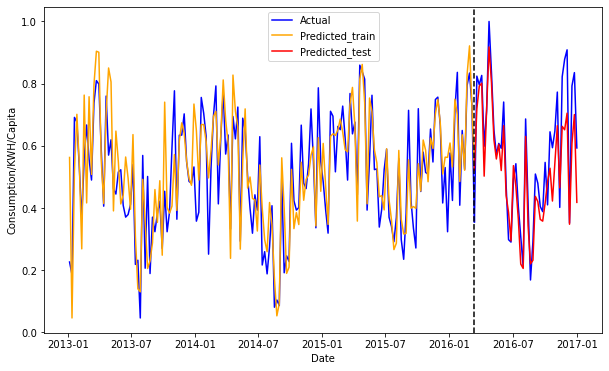

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(train.index, train['Consumption/KWH'], "b",label='Actual')
plt.plot(train.index, predictions_train,"orange", label='Predicted_train')
plt.plot(tests.index, tests['Consumption/KWH'],"b" )
plt.plot(predictions_test.index, predictions_test, "r", label='Predicted_test')
plt.axvline(x=train.index[-1], color='k', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Consumption/KWH/Capita')
plt.legend()

# Set custom ticker for x-axis labels
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%b'))

#plt.grid(True)
plt.show()

## Evaluation:

In [27]:
import numpy as np
mape = np.mean(np.abs((predictions_test - test['Consumption/KWH']) / test['Consumption/KWH'])) * 100
mse = np.mean((predictions_test - test['Consumption/KWH']) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_test - test['Consumption/KWH']))

mape_train = np.mean(np.abs((predictions_train - train['Consumption/KWH']) / train['Consumption/KWH'])) * 100
mse_train = np.mean((predictions_train - train['Consumption/KWH']) ** 2)
rmse_train = np.sqrt(mse_train)
mae_train = np.mean(np.abs(predictions_train - train['Consumption/KWH']))


# Print the results
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE_train: ", rmse_train)
print("MAPE_train: ", mape_train)
print("MAE_train: ", mae_train)

RMSE:  0.09586004655307945
MAPE:  13.57435190044731
MAE:  0.0766903104573554
RMSE_train:  0.10744627937824963
MAPE_train:  21.170697277456625
MAE_train:  0.08221607910154165


In [107]:
df1_resampled

,Tmean,RH,Wind,Consumption/KWH
Date,,,,
2013-01-06,27.650000,74.850000,2.980000,1.155943
2013-01-13,26.428571,81.828571,3.494286,1.140486
2013-01-20,28.485714,80.842857,3.384286,1.332617
2013-01-27,28.485714,80.428571,3.667143,1.327037
2013-02-03,27.871429,73.671429,2.687143,1.271762
...,...,...,...,...
2016-12-04,28.385714,81.428571,3.244286,1.415145
2016-12-11,26.300000,85.314286,3.438571,1.203439
2016-12-18,27.942857,83.200000,2.645714,1.371090


# LSTM

In [159]:
train_size = int(0.8 * df2.shape[0])  # the number of elements we want in the training set.
train = df2.iloc[:train_size, :] # selecting all the rows and stops in the train size and all the columns are included.
test = df2.iloc[train_size:, :] 

In [160]:
# Assuming you have the training and test data
train_data = train[['Tmean', 'Wind', 'RH', 'Consumption/KWH']]
test_data = test[['Tmean', 'Wind', 'RH', 'Consumption/KWH']]

In [162]:
train_data

,Tmean,Wind,RH,Consumption/KWH
Date,,,,
2013-01-06,0.630312,0.404750,0.603979,0.226256
2013-01-13,0.388102,0.621205,0.786906,0.185557
2013-01-20,0.796034,0.574907,0.757381,0.691456
2013-01-27,0.796034,0.693957,0.744972,0.676764
2013-02-03,0.674221,0.281491,0.603979,0.531219
...,...,...,...,...
2016-02-14,0.521246,0.571901,0.866923,0.524139
2016-02-21,0.881020,0.792564,0.786050,0.794303
2016-02-28,0.968839,0.846678,0.746256,0.834172


In [99]:
# #Scale the data
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_data)
# test_scaled = scaler.transform(test_data)
# test_scaled

In [165]:
# Split the data into input (X) and target (y) variables
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]


#Convert DataFrame to numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [166]:
X_train 

array([[0.63031161, 0.40474997, 0.60397946],
       [0.38810198, 0.62120453, 0.78690629],
       [0.79603399, 0.57490731, 0.75738126],
       [0.79603399, 0.69395731, 0.74497219],
       [0.67422096, 0.28149113, 0.60397946],
       [0.33144476, 0.500952  , 0.81386393],
       [0.79320113, 0.67712196, 0.77321352],
       [0.82152975, 0.69275479, 0.71116816],
       [0.7733711 , 0.59414771, 0.67950364],
       [0.36260623, 0.6554765 , 0.8245614 ],
       [0.77620397, 0.60136286, 0.75267437],
       [0.89235127, 0.83886161, 0.70261018],
       [0.83286119, 0.60196412, 0.66452717],
       [0.66005666, 0.59054013, 0.72058194],
       [0.49575071, 0.5652871 , 0.80530595],
       [0.80736544, 0.50756589, 0.70047069],
       [0.72521246, 0.33079467, 0.73727   ],
       [0.77053824, 0.44503457, 0.6961917 ],
       [0.33427762, 0.69936867, 0.84296106],
       [0.59490085, 0.19310552, 0.77963201],
       [0.63172805, 0.35725023, 0.81985451],
       [0.54957507, 0.37709189, 0.76251605],
       [0.

In [167]:
# Reshape the input data to be 3D (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0],1 , X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [168]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= optimizer, loss='mse')

In [169]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
6/6 [==============================] - 4s 172ms/step - loss: 0.2472 - val_loss: 0.2555
Epoch 2/100
6/6 [==============================] - 0s 25ms/step - loss: 0.1538 - val_loss: 0.1619
Epoch 3/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0871 - val_loss: 0.0945
Epoch 4/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0456 - val_loss: 0.0549
Epoch 5/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0304 - val_loss: 0.0387
Epoch 6/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0308 - val_loss: 0.0352
Epoch 7/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0316 - val_loss: 0.0341
Epoch 8/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0307 - val_loss: 0.0339
Epoch 9/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0278 - val_loss: 0.0354
Epoch 10/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0260 - val_loss: 0.0364
Epoch 11/100
6/6 [

Epoch 84/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 85/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 86/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0092 - val_loss: 0.0071
Epoch 87/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 88/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0092 - val_loss: 0.0100
Epoch 89/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0094 - val_loss: 0.0076
Epoch 90/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 91/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0090 - val_loss: 0.0069
Epoch 92/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 93/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 94/1

In [170]:
# Make predictions
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Rescale the predictions
predictions_train = scaler.inverse_transform(np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[2]), predictions_train), axis=1))[:, -1]
predictions_test = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], X_test.shape[2]), predictions_test), axis=1))[:, -1]

2/2 [==============================] - 0s 6ms/step


In [171]:
# Calculate the training loss and test loss
train_loss = np.sqrt(np.mean((predictions_train - train_data['Consumption/KWH'].values) ** 2))
test_loss = np.sqrt(np.mean((predictions_test - test_data['Consumption/KWH'].values) ** 2))

# Print the training loss and test loss
print("Training Loss:", train_loss)
print("Test Loss:", test_loss)

Training Loss: 0.7742564883775483
Test Loss: 0.7099563614311658


In [134]:
predictions_test

array([1.35584602, 1.37702307, 1.37259021, 1.27535941, 1.35302393,
       1.41973033, 1.37156804, 1.31431437, 1.2878491 , 1.30687379,
       1.2850853 , 1.32974192, 1.24532992, 1.21055312, 1.19427416,
       1.2711482 , 1.25419638, 1.22081227, 1.16219008, 1.15167682,
       1.30952698, 1.218123  , 1.15844837, 1.16571169, 1.25716659,
       1.2401323 , 1.21508389, 1.21099088, 1.24836138, 1.25370212,
       1.28541145, 1.25736937, 1.29370832, 1.32426   , 1.25030268,
       1.34266638, 1.32647653, 1.34510713, 1.21877846, 1.3158413 ,
       1.34362174, 1.2394371 ])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

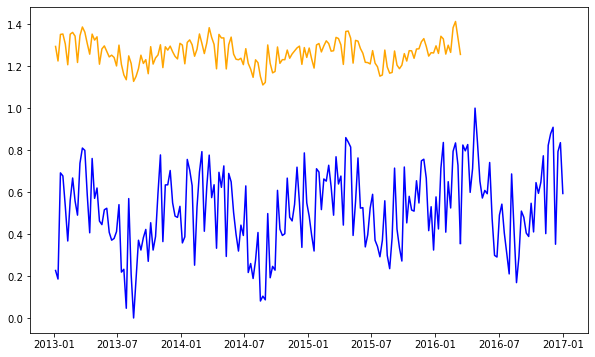

In [174]:
# #Plot the actual data, predictions on the training set, and predictions on the test set
# plt.figure(figsize=(10, 6))
# plt.plot( df2[['Consumption/KWH']], label='Actual Data')
# #plt.plot(train.index, train_data['Consumption/KWH'], label='Actual Data')
# #plt.plot(train.index, predictions_train, label='Train Predictions')
# plt.plot(test.index, predictions_test, label='Test Predictions')
# #plt.axvline(x=dates_train[-1], color='black', linestyle='--')
# plt.xlabel('Date')
# plt.ylabel('Consumption/KWH/Capita') 
# plt.title('Actual Data vs. Predictions')
# plt.legend()
# plt.show()


plt.figure(figsize=(10, 6))

plt.plot(train.index, train['Consumption/KWH'], "b",label='Actual')
plt.plot(train.index, predictions_train,"orange", label='Predicted_train')
plt.plot(tests.index, tests['Consumption/KWH'],"b" )
plt.plot(predictions_test.index, predictions_test, "r", label='Predicted_test')
plt.axvline(x=train.index[-1], color='k', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Consumption/KWH/Capita')
plt.legend()

# Set custom ticker for x-axis labels
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%b'))

#plt.grid(True)
plt.show()

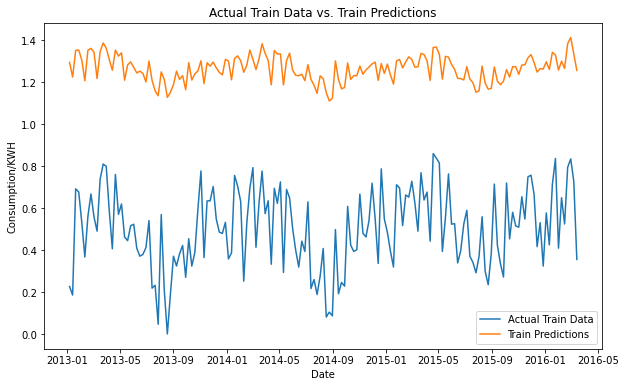

In [173]:
# Plot the actual data and predictions on the training set
plt.figure(figsize=(10, 6))
plt.plot(train.index, train_data['Consumption/KWH'], label='Actual Train Data')
plt.plot(train.index, predictions_train, label='Train Predictions')
plt.xlabel('Date')
plt.ylabel('Consumption/KWH')
plt.title('Actual Train Data vs. Train Predictions')
plt.legend()
plt.show()


## Loss

In [128]:
train_data

,Tmean,Wind,RH,Consumption/KWH
Date,,,,
2013-01-06,0.630312,0.404750,0.603979,0.226256
2013-01-13,0.388102,0.621205,0.786906,0.185557
2013-01-20,0.796034,0.574907,0.757381,0.691456
2013-01-27,0.796034,0.693957,0.744972,0.676764
2013-02-03,0.674221,0.281491,0.603979,0.531219
...,...,...,...,...
2016-02-14,0.521246,0.571901,0.866923,0.524139
2016-02-21,0.881020,0.792564,0.786050,0.794303
2016-02-28,0.968839,0.846678,0.746256,0.834172


In [ ]:
# Extract the training loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training loss and validation loss
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.legend()
plt.show()

## Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAPE (Mean Absolute Percentage Error)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAE (Mean Absolute Error)
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Calculate RMSE (Root Mean Squared Error)
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Assuming you have the actual test values and the predictions
y_true = test_data['Consumption/KWH'].values
y_pred = predictions_test

# Calculate evaluation metrics
mape = calculate_mape(y_true, y_pred)
mae = calculate_mae(y_true, y_pred)
rmse = calculate_rmse(y_true, y_pred)

mape_train = np.mean(np.abs((predictions_train - train['Consumption/KWH']) / train['Consumption/KWH'])) * 100
mse_train = np.mean((predictions_train - train['Consumption/KWH']) ** 2)
rmse_train = np.sqrt(mse_train)
mae_train = np.mean(np.abs(predictions_train - train['Consumption/KWH']))



# Print the evaluation metrics
print("MAPE:", mape)
print("MAE:", mae)
print("RMSE:", rmse)
print("RMSE_train: ", rmse_train)
print("MAPE_train: ", mape_train)
print("MAE_train: ", mae_train)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the actual data, train predictions, test predictions, and dates
actual_data_train = train_data['Consumption/KWH'].values
actual_data_test = test_data['Consumption/KWH'].values
dates_train = train_data.index
dates_test = test_data.index

# Plot the actual data, train predictions, and test predictions
plt.figure(figsize=(14, 6))
plt.plot(dates_train, actual_data_train, label='Actual Train Data')
plt.plot(dates_test, actual_data_test, label='Actual Test Data')
plt.plot(dates_train, predictions_train, label='Train Predictions')
plt.plot(dates_test, predictions_test, label='Test Predictions')
plt.axvline(x=dates_train[-1], color='black', linestyle='--', label='Train/Test Separator')
plt.xlabel('Date')
plt.ylabel('Consumption/KWH')
plt.title('Actual Data vs. Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Forecasting

In [ ]:
data1 = pd.read_csv('Lome2.csv')
data1

In [ ]:
data1.Date = data1.Date.map(lambda date: date.split('/')[1] + '/' + date.split('/')[0] + '/' + date.split('/')[-1])

In [ ]:
data1.Date[1].split('/')[1] + '/' + data1.Date[1].split('/')[0] + '/' + data1.Date[1].split('/')[-1]

In [ ]:
# set the Date as datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1

In [ ]:
data1.set_index('Date', inplace=True)
data2= data1.asfreq('D')
data2

In [ ]:
#future_data = df[['Tmean', 'Wind', 'RH']]


In [ ]:

# initialize the MinMaxScaler object
scaler = MinMaxScaler()

# fit the scaler object to the dataframe
scaler.fit(data2)
data2_scaled = scaler.transform(data2)
data2_scaled 

In [ ]:
# create a new dataframe with the scaled values
df3 = pd.DataFrame(data2_scaled, columns=data2.columns)
df3.index = data2.index
# print the scaled dataframe
df3

In [ ]:
df4= df3[['Tmean','RH','Wind']]

In [ ]:
forecast_ = reg.predict(df4)

In [ ]:
plt.plot(forecast_)

In [ ]:
# Plot the actual data, predictions on the training set, and predictions on the test set
plt.figure(figsize=(10, 6))

plt.plot( df2[['Consumption/KWH']], label='Actual Data')
plt.plot(df3.index, forecast_, label = 'Forecasting')
plt.plot(train.index, predictions_train, label='Train Predictions', color = 'red')
plt.plot(test.index, predictions_test, label='Test Predictions')

# Add a vertical line to separate train and test predictions
plt.axvline(x=train.index[-1], color='black', linestyle='--')
plt.axvline(df3.index[0], color='black', ls='--')

plt.xlabel('Date')
plt.ylabel('Consumption/KWH/Capita')
plt.title('Actual Data vs. Predictions')
plt.legend()
plt.show()